In [145]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator
import scipy.io as sio
import numpy as np
import pandas as pd

In [146]:
def get_lag_llama_predictions(dataset, prediction_length, context_length, num_samples, device, batch_size, nonnegative_pred_samples=False):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    # print(forecast_it, ts_it)
    forecasts = list(tqdm(forecast_it, total=len(dataset)))
    tss = list(tqdm(ts_it, total=len(dataset)))

    return forecasts, tss

### Zero-Shot

In [147]:
data = sio.loadmat('D:\\ly\\sEMG\\SIAT-UPS\\emg_features_examples.mat')

semg_data = data['examples']  # shape: (samples, 9, 6)
joint_angles = data['angle_labels']  # shape: (samples, 8)
joint_torques = data['torque_labels']  # shape: (samples, 8)

angles_name = data['angle_name']
torques_name = data['torque_name']

# 重塑sEMG数据
semg_reshaped = semg_data.reshape(semg_data.shape[0], -1)  # shape: (samples, 54)

# 创建时间索引
num_samples = semg_data.shape[0]
sampling_rate = 1926  # Hz
time_index = pd.timedelta_range(start='0 seconds', 
                                periods=num_samples, 
                                freq=f'{1000/sampling_rate:.3f}ms')

# 创建DataFrame
df = pd.DataFrame(
    np.hstack((joint_angles, semg_reshaped, joint_torques)),
    index=time_index,
    columns=[f'{angles_name[i]}' for i in range(8)] + [f'semg_{i}' for i in range(54)] + [f'{torques_name[i]}' for i in range(8)]
)
df.index = df.index.total_seconds()
df

,left hip adduction,left hip flexion,left knee flexion,left ankle flexion,right hip adduction,right hip flexion,right knee flexion,right ankle flexion,semg_0,semg_1,...,semg_52,semg_53,left hip adduction torque,left hip flexion torque,left knee flexion torque,left ankle flexion torque,right hip adduction torque,right hip flexion torque,right knee flexion torque,right ankle flexion torque
0.000000,-2.911356,38.685166,92.807369,13.114965,-2.108089,26.361162,35.455239,-1.194237,0.464151,0.000033,...,1.0,81.0,-12.291363,15.570726,0.331848,5.698510,-40.170709,-30.408407,-66.165885,-10.026001
0.000519,-3.916039,39.976656,94.446092,10.574270,-1.639000,25.718500,36.043649,-0.575133,0.458580,0.000032,...,0.0,87.0,-11.270131,16.087237,-1.825978,6.062143,-42.344766,-26.181394,-71.583512,-7.551678
0.001038,-4.704382,41.145805,94.759461,9.079517,-1.245771,25.145880,36.316621,-0.087085,0.349124,0.000022,...,0.0,86.0,-10.280912,16.562719,-3.546804,6.066180,-42.859676,-23.273704,-72.653933,-5.573360
0.001557,-5.167445,42.142139,93.638669,8.519608,-0.998886,24.654968,36.353371,0.334465,0.338890,0.000019,...,0.0,85.0,-9.724392,16.909505,-4.391324,5.928014,-42.396313,-24.082428,-69.565141,-3.891667
0.002076,-5.279042,42.912946,91.085285,8.425922,-0.915321,24.233310,36.239775,0.765962,0.695603,0.000077,...,0.0,87.0,-10.077636,17.209314,-4.359085,5.822574,-41.532447,-25.538030,-65.141425,-1.583036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.352493,-3.552101,29.971559,58.804591,-1.473442,-1.000199,2.639377,19.435343,8.386818,0.143894,0.000003,...,3.0,90.0,-3.757517,0.651826,4.095271,1.988317,-21.119843,-2.046989,-2.666608,-54.869099
10.353012,-3.133334,28.192172,50.343723,-5.027025,-0.978156,2.092506,19.864062,8.986606,0.134094,0.000003,...,2.0,85.0,-3.885409,-0.470513,5.361873,2.137944,-20.844920,-0.465285,-2.357848,-58.259503
10.353531,-2.773739,25.794942,41.727031,-8.542155,-0.847580,1.626593,20.943839,9.811705,0.137239,0.000003,...,2.0,90.0,-3.392870,-3.119011,6.809699,2.586792,-21.406693,3.405630,-4.794125,-62.016538
10.354050,-2.595149,22.963306,33.396294,-11.767030,-0.610220,1.333837,22.751226,10.850543,0.140257,0.000003,...,3.0,92.0,-2.848430,-6.010877,8.151218,2.526886,-21.425267,8.116903,-9.237328,-65.692862


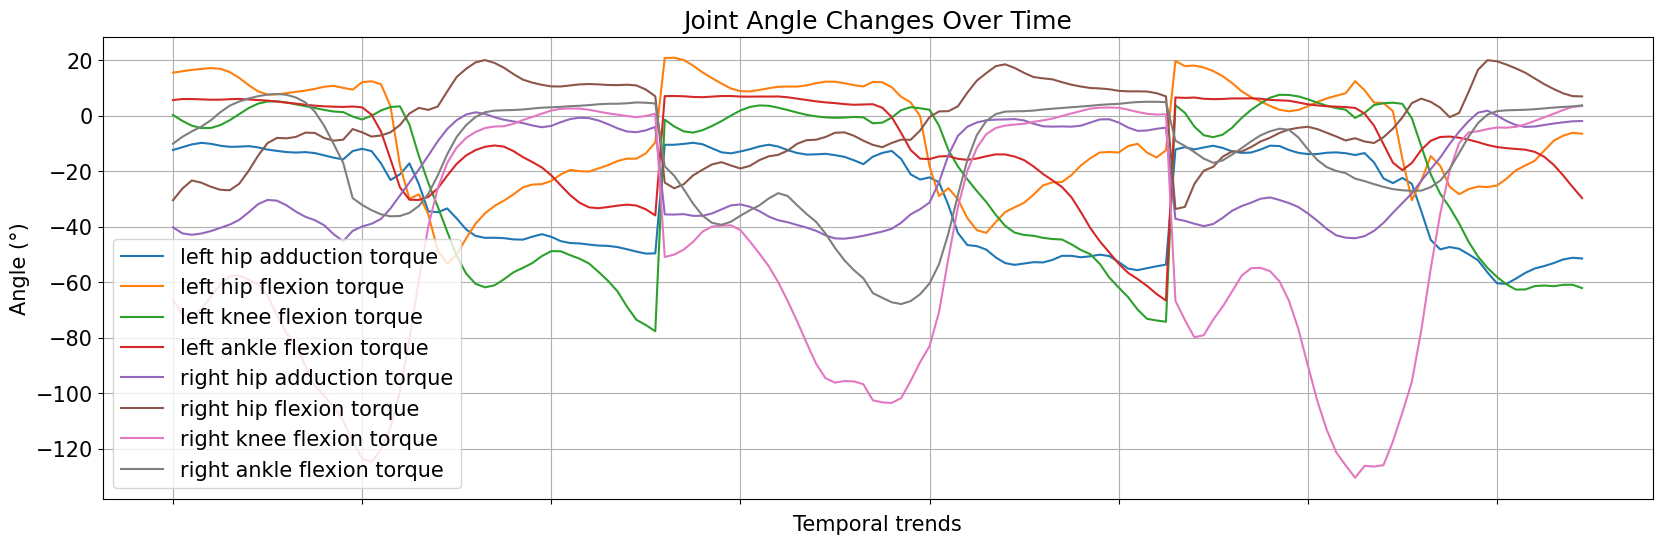

In [148]:
# 创建图形
plt.figure(figsize=(20, 6))

# 绘制每个关节的角度变化
for i in range(8):
    # plt.plot(joint_angles[:150, i], label=f'{angles_name[i]}')
    plt.plot(joint_torques[:150, i], label=f'{torques_name[i]}')

plt.title('Joint Angle Changes Over Time')
# plt.title('Joint Torque Changes Over Time')
plt.gca().xaxis.set_ticklabels([])
plt.xlabel('Temporal trends')
plt.ylabel('Angle (°)')
# plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)

# 显示图形
plt.show()

In [149]:
from gluonts.dataset.common import ListDataset

def prepare_data_for_gluonts(df):
    # target_variables = [f'{angles_name[i]}' for i in range(8)]
    target_variables = [f'{torques_name[i]}' for i in range(8)]
    '''
    target_variables = ['semg_0', 'semg_1', 'semg_2', 'semg_3', 'semg_4', 'semg_5', 'semg_6', 'semg_7',
                       'semg_8', 'semg_9', 'semg_10', 'semg_11', 'semg_12', 'semg_13', 'semg_14', 'semg_15',
                       'semg_16', 'semg_17', 'semg_18', 'semg_19', 'semg_20', 'semg_21', 'semg_22', 'semg_23',
                       'semg_24', 'semg_25', 'semg_26', 'semg_27', 'semg_28', 'semg_29', 'semg_30', 'semg_31',
                       'semg_32', 'semg_33', 'semg_34', 'semg_35', 'semg_36', 'semg_37', 'semg_38', 'semg_39',
                       'semg_40', 'semg_41', 'semg_42', 'semg_43', 'semg_44', 'semg_45', 'semg_46', 'semg_47',
                       'semg_48', 'semg_49', 'semg_50', 'semg_51', 'semg_52', 'semg_53']
    '''
    
    # 创建一个字典来存储每个目标变量的时间序列
    data = []
    for var in target_variables:
        ts = {
            "target": df[var].values,
            "start": pd.Timestamp("2023-01-01"),  # 使用一个任意的开始日期
            "item_id": var
        }
        data.append(ts)
    
    return ListDataset(data, freq="0.5L")  # 假设频率是1ms

# 准备数据
gluonts_dataset = prepare_data_for_gluonts(df)
gluonts_dataset

[{'target': array([-12.291363 , -11.270131 , -10.280911 , ...,  -3.3928702,
          -2.8484302,  -1.8976874], dtype=float32),
  'start': Period('2023-01-01 00:00:00.000000', '500U'),
  'item_id': 'left hip adduction torque '},
 {'target': array([15.570726 , 16.087236 , 16.56272  , ..., -3.1190112, -6.0108767,
         -8.769617 ], dtype=float32),
  'start': Period('2023-01-01 00:00:00.000000', '500U'),
  'item_id': 'left hip flexion torque   '},
 {'target': array([ 0.3318477, -1.8259777, -3.5468042, ...,  6.8096986,  8.151218 ,
          9.281079 ], dtype=float32),
  'start': Period('2023-01-01 00:00:00.000000', '500U'),
  'item_id': 'left knee flexion torque  '},
 {'target': array([5.6985097, 6.0621433, 6.06618  , ..., 2.5867918, 2.5268865,
         2.3191757], dtype=float32),
  'start': Period('2023-01-01 00:00:00.000000', '500U'),
  'item_id': 'left ankle flexion torque '},
 {'target': array([-40.170708, -42.344765, -42.859676, ..., -21.406693, -21.425266,
         -21.113586], dt

In [150]:
prediction_length = 128

context_length = prediction_length*2
num_samples = 200
device = "cuda"
batch_size = 1

forecasts, tss = get_lag_llama_predictions(
    gluonts_dataset,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device,
    batch_size=batch_size
)

C:\Users\linhy\AppData\Local\Temp\ipykernel_3352\2650622613.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)
d:\A

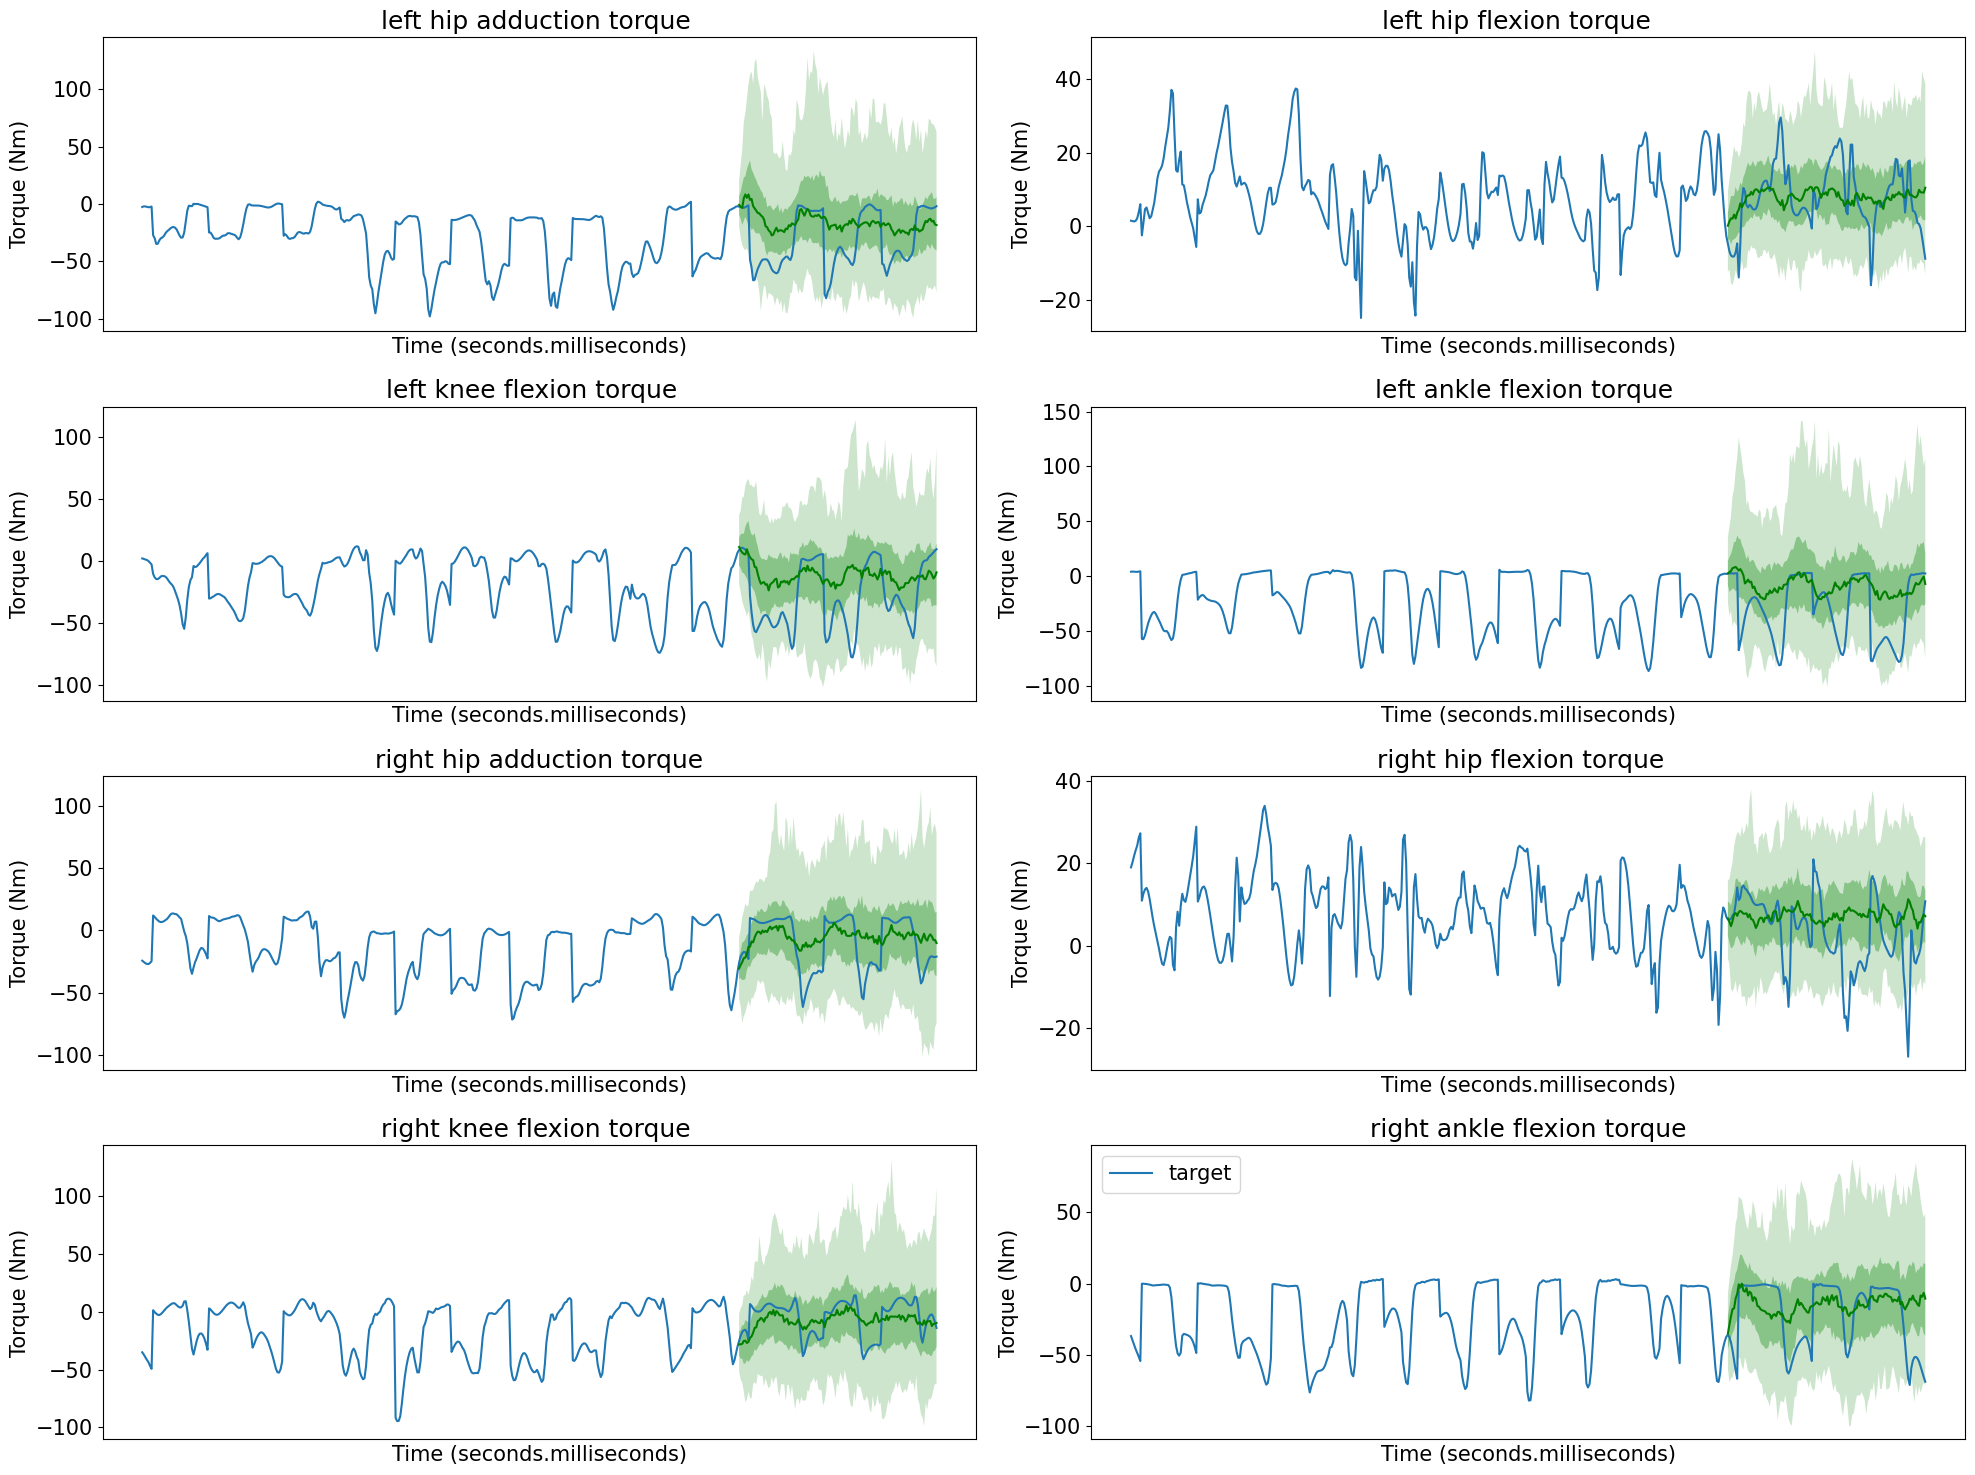

In [152]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in enumerate(zip(forecasts, tss)):
    ax = plt.subplot(4, 2, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot(color='g')

    ax.set_xticks([])
    ax.set_xlabel('Time (seconds.milliseconds)')
    # ax.set_ylabel('Angle (°)')
    ax.set_ylabel('Torque (Nm)')

    ax.set_title(forecast.item_id)
    
# plt.title("Lag-Llama predicts the joint angle of the DNS")
plt.gcf().tight_layout()
plt.legend()
plt.show()